Saturation curves for SM-omics and ST<br>

Input files are generated by counting number of unique molecules and number of annotated reads per annotated region after adjusting for sequencing depth, in downsampled fastq files (proportions 0.001, 0.01, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1) processed using ST-pipeline.<br>

data files needed to run are available at SCP: https://singlecell.broadinstitute.org/single_cell/study/SCP979/<br>
please download:<br>
10005CN48_C1_uniq_molecules_per_region_adjusted_after_seq_depth_on_tot_count.txt<br>
10005CN48_D1_uniq_molecules_per_region_adjusted_after_seq_depth_on_tot_count.txt<br>
10005CN48_E1_uniq_molecules_per_region_adjusted_after_seq_depth_on_tot_count.txt<br>
10015CN60_E2_uniq_molecules_per_region_adjusted_after_seq_depth_on_tot_count.txt<br>
10015CN84_C2_uniq_molecules_per_region_adjusted_after_seq_depth_on_tot_count.txt<br>
10015CN84_D2_uniq_molecules_per_region_adjusted_after_seq_depth_on_tot_count.txt<br>

To generate SM-omics vs Visium, saturation curve for the entire tissue section, download:<br>
10015CN108_C1_uniq_molecules.txt<br>
10015CN108fl_E2_uniq_molecules.txt<br>
5005CN107_D2_uniq_molecules.txt<br>
visium_A1_uniq_molecules.txt<br>
visium_B1_uniq_molecules.txt<br>
visium_D1_uniq_molecules.txt <br>


In [1]:
%matplotlib inline
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import warnings
from scipy.stats import ranksums, ttest_ind
warnings.filterwarnings('ignore')

In [2]:
def condition(row):
    """ Takes row in pandas df as input and returns type of condition
    """
    # The samples are run in triplicate based on condition
    condition = ['sm-omics', 'ST']

    if row['Name'] in ['10015CN84_D2', '10015CN84_C2', '10015CN60_E2']:
        return condition[0]
    
    elif row['Name'] in ['10005CN48_C1','10005CN48_D1','10005CN48_E1']:
        return condition[1]
    

In [30]:
# Load input files
path = '../../smomics_data'

stats_list = []

samples_list = ['10005CN48_C1', '10005CN48_D1', '10005CN48_E1', '10015CN84_D2', '10015CN84_C2', '10015CN60_E2']
    
for filename in samples_list:
    
    cond_file = pd.read_csv(os.path.join(path, filename + '_uniq_molecules_per_region_adjusted_after_seq_depth_on_tot_count.txt'), sep = '\t')
    
    cond_file['Condition'] = cond_file.apply(lambda row: condition(row), axis = 1)
    
    stats_list.append(cond_file)

# Concat all files
cond_merge = pd.concat(stats_list)
    

In [31]:
prop_list = [0.001, 0.01, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1]

cond_list = []
for label, df in cond_merge.groupby(['Condition', 'Name', 'Annotated_region']):
    
    # Sort df by annotated reads
    df.sort_values(by='Annotated_reads', inplace=True)
    
    df['Prop_annot_reads'] = prop_list
        
    cond_list.append(df)
    
# Concatenate all dfs in list
plot_df_tmp = pd.concat(cond_list)

# Remove 'unknown' regions, if any
plot_df_big = plot_df_tmp[plot_df_tmp['Annotated_region'] != 'Unknown']
plot_df_big_max = plot_df_big[plot_df_big['Prop_annot_reads'] == 1.000]

In [32]:
# Prepare samples for plotting
ll = []

for label, df in plot_df_big.groupby(['Name']):
    # Get max annotated reads
    max_annot = df['Annotated_reads'].max()
    
    # Get tot number of uniq mol at that amount of annotated reads
    tot_uniq_mol = df[df['Annotated_reads'] == max_annot]['Unique_molecules'].sum()
       
    df['Prop_uniq_mol'] = df['Unique_molecules'] / tot_uniq_mol
    ll.append(df)

# Concatenate all dfs in list
prop_df = pd.concat(ll)
plot_dict = {}

# Get a df per annotated region
for label, df in prop_df.groupby(['Annotated_region']):
        
    df.drop(['Num reads', 'Annotated_reads', 'Unique_molecules'], axis=1, inplace=True)

    plot_dict[label] = df

plot_dict_all = {}
    
for label in ['sm-omics', 'ST']:
    df = plot_df_big[plot_df_big['Condition'] == label]
    df = df.groupby(['Condition', 'Name', 'Prop_annot_reads']).sum()    
    df['Prop_annot_reads'] = list(df.index.get_level_values(2))
    df['Condition'] = list(df.index.get_level_values(0))
    plot_dict_all[label] = df

In [45]:
plot_df_big_max.groupby(['Condition', 'Name']).sum()

Unique_molecules  Number of genes  Num reads  \
Condition Name                                                         
ST        10005CN48_C1         1822372.0            50806  383529330   
          10005CN48_D1         1668179.0            49017  408393582   
          10005CN48_E1         1118110.0            46309  316566066   
sm-omics  10015CN60_E2         1405287.0            59582  182909370   
          10015CN84_C2         1405054.0            52860  259214130   
          10015CN84_D2         1108559.0            52196  222973410   

                        Annotated_reads  Prop_annot_reads  
Condition Name                                             
ST        10005CN48_C1        134829576               6.0  
          10005CN48_D1        131960568               6.0  
          10005CN48_E1        101713710               6.0  
sm-omics  10015CN60_E2         83668488               6.0  
          10015CN84_C2        106006938               6.0  
          10015CN84_D2         96001710               6.0

GL
            Name Annotated_region  Number of genes Condition  \
30  10005CN48_C1               GL             1425        ST   
36  10005CN48_C1               GL             5063        ST   
12  10005CN48_C1               GL            10474        ST   
42  10005CN48_C1               GL            10031        ST   
0   10005CN48_C1               GL            11209        ST   
6   10005CN48_C1               GL            10404        ST   
18  10005CN48_C1               GL             9638        ST   
24  10005CN48_C1               GL             9019        ST   
48  10005CN48_C1               GL             8536        ST   
24  10005CN48_D1               GL             1255        ST   
36  10005CN48_D1               GL             6646        ST   
12  10005CN48_D1               GL            10296        ST   
42  10005CN48_D1               GL            11064        ST   
0   10005CN48_D1               GL            11004        ST   
6   10005CN48_D1               GL    

IPL
            Name Annotated_region  Number of genes Condition  \
32  10005CN48_C1              IPL              657        ST   
38  10005CN48_C1              IPL             1827        ST   
14  10005CN48_C1              IPL             7417        ST   
44  10005CN48_C1              IPL             5723        ST   
2   10005CN48_C1              IPL             9384        ST   
8   10005CN48_C1              IPL             9447        ST   
20  10005CN48_C1              IPL             9143        ST   
26  10005CN48_C1              IPL             8721        ST   
50  10005CN48_C1              IPL             8358        ST   
26  10005CN48_D1              IPL              287        ST   
38  10005CN48_D1              IPL             2492        ST   
14  10005CN48_D1              IPL             5696        ST   
44  10005CN48_D1              IPL             6987        ST   
2   10005CN48_D1              IPL             7885        ST   
8   10005CN48_D1              IPL   

ONL
            Name Annotated_region  Number of genes Condition  \
34  10005CN48_C1              ONL              855        ST   
40  10005CN48_C1              ONL             5427        ST   
16  10005CN48_C1              ONL             9189        ST   
46  10005CN48_C1              ONL            10132        ST   
4   10005CN48_C1              ONL            10654        ST   
10  10005CN48_C1              ONL            10185        ST   
22  10005CN48_C1              ONL             9549        ST   
28  10005CN48_C1              ONL             8970        ST   
52  10005CN48_C1              ONL             8515        ST   
28  10005CN48_D1              ONL              515        ST   
40  10005CN48_D1              ONL             4007        ST   
16  10005CN48_D1              ONL             7940        ST   
46  10005CN48_D1              ONL             9175        ST   
4   10005CN48_D1              ONL             9765        ST   
10  10005CN48_D1              ONL   

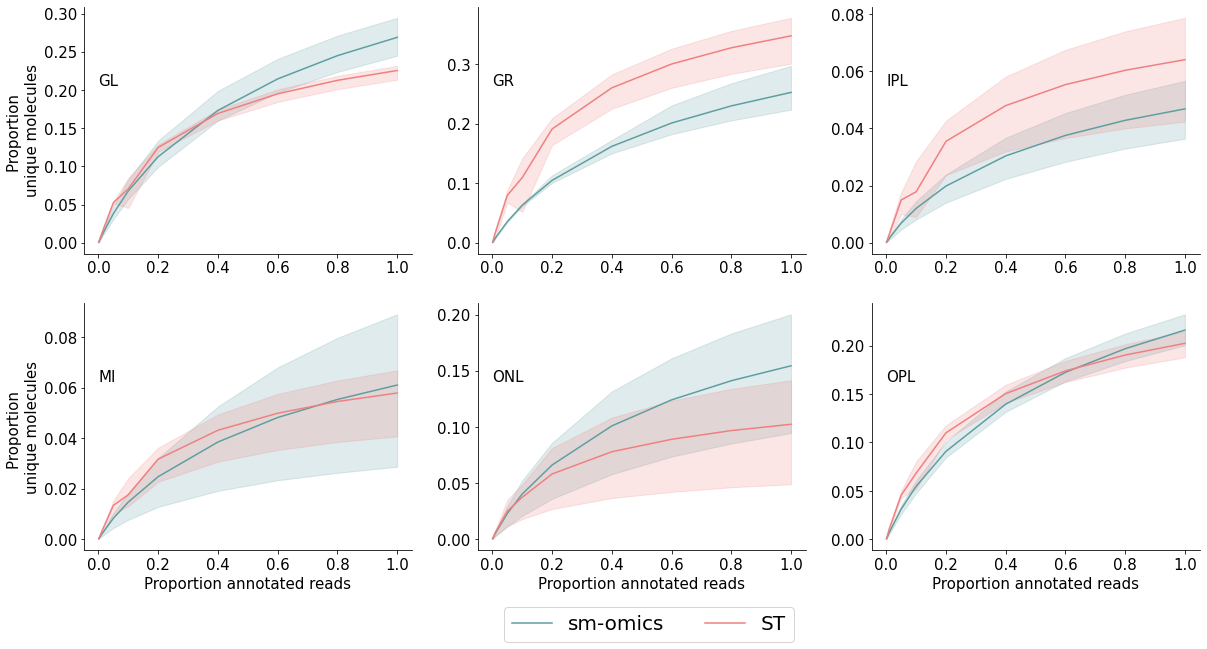

In [42]:
#Plot 
fig = plt.figure(figsize=(20, 10))
# for a 2x3 subplot
axes = []
for row_idx in range(0,2):
    for col_idx in range(0,3):
        ax = plt.subplot2grid((2, 3), (row_idx, col_idx))
        axes.append(ax) 

x="Prop_annot_reads"
y="Prop_uniq_mol"
hue='Condition'
hue_order=['sm-omics', 'ST']
palette = ['cadetblue', 'lightcoral']
err_style="band"
ci=95

################ LINE PLOT
count = 0
for key, value in plot_dict.items():
    
    ax=axes[count]
    print(key)
    print(value)
    
    if count == 4:
        sns.lineplot(x=x, y=y, data=value, ci=ci, err_style=err_style, hue=hue, 
                 palette = palette, ax=ax, hue_order=hue_order)
    else:
        sns.lineplot(x=x, y=y, data=value, ci=ci, err_style=err_style, hue=hue, 
                 palette = palette, ax=ax, hue_order=hue_order, 
                legend=False)
        
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('k')
    ax.spines['left'].set_color('k')
    
    # X and y label size
    if count in [3, 4, 5]:
        ax.set_xlabel("Proportion annotated reads", fontsize=15)
    else:
        ax.set_xlabel("")
        
    if count in [0, 3]:
        ax.set_ylabel("Proportion \nunique molecules", fontsize=15)
    else:
        ax.set_ylabel("")
    
    # Set ticks size
    ax.tick_params(axis='y', labelsize=15)
    ax.tick_params(axis='x', labelsize=15)
    
    # change background color
    back_c = 'white'
    ax.set_facecolor(back_c)
    ax.grid(False)
    
    # text
    ax.text(0, max(value[y])-0.3*max(value[y]), key, fontsize=15)
    
    count += 1

# LEGEND
handles, labels = axes[4].get_legend_handles_labels()
axes[4].legend(handles=handles[0:], labels=hue_order,loc='center left', bbox_to_anchor=(0.05, -0.3), ncol=2, fontsize=20)
        
plt.show()

sm-omics
                                         Unique_molecules  Number of genes  \
Condition Name         Prop_annot_reads                                      
sm-omics  10015CN60_E2 0.001                       2386.0             1889   
                       0.010                      36036.0            15620   
                       0.050                     167415.0            35576   
                       0.100                     306407.0            44963   
                       0.200                     529049.0            52573   
                       0.400                     853565.0            58002   
                       0.600                    1087329.0            59515   
                       0.800                    1264573.0            59824   
                       1.000                    1405287.0            59582   
          10015CN84_C2 0.001                       4093.0             2999   
                       0.010                      52587

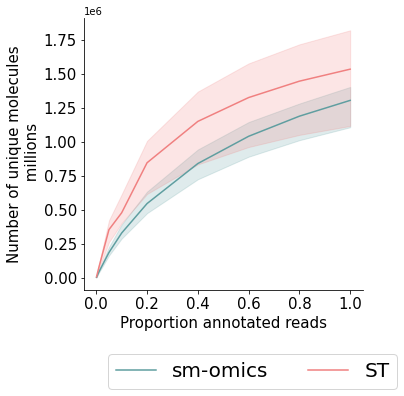

In [39]:
#Plot 
fig = plt.figure(figsize=(5, 5)) 

x="Prop_annot_reads"
y="Unique_molecules"
hue='Condition'
hue_order=['sm-omics', 'ST']
palette = ['cadetblue', 'lightcoral']
err_style="band"
ci=95

################ LINE PLOT
count = 0
for key, value in plot_dict_all.items():
    
    print(key)
    print(value)
    
    ax = sns.lineplot(x=x, y=y, data=value, ci=ci, err_style=err_style, hue=hue, 
                 palette = palette, hue_order=hue_order, )
     
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('k')
    ax.spines['left'].set_color('k')
    
    # X and y label size
    ax.set_xlabel("Proportion annotated reads", fontsize=15)
    ax.set_ylabel("Number of unique molecules\n millions", fontsize=15)
    
    # Set ticks size
    ax.tick_params(axis='y', labelsize=15)
    ax.tick_params(axis='x', labelsize=15)
    
    # change background color
    back_c = 'white'
    ax.set_facecolor(back_c)
    ax.grid(False)
    

# LEGEND
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=hue_order,loc='center left', bbox_to_anchor=(0.05, -0.3), ncol=2, fontsize=20)
        

plt.show()

In [10]:
# Calculate statistical tests
for key, cond_merge in plot_dict.items():
    print(key)
    #print(cond_merge.head())
    st = cond_merge[((cond_merge['Prop_annot_reads'] == 1) & (cond_merge['Condition'] == 'ST'))]['Prop_uniq_mol'].tolist()
    sm = cond_merge[((cond_merge['Prop_annot_reads'] == 1) & (cond_merge['Condition'] == 'sm-omics'))]['Prop_uniq_mol'].tolist()
    # The Wilcoxon rank-sum test tests the null hypothesis that two sets of measurements are drawn from the same distribution.
#     print('Wilcoxon’s rank sum test')
#     print(ranksums(sm, st))
    #Calculate the T-test for the means of two independent samples of scores.
    print('Welch’s t-test')
    print(ttest_ind(sm, st, equal_var=False))

GL
Welch’s t-test
Ttest_indResult(statistic=2.9332979822358314, pvalue=0.05653554968823582)
GR
Welch’s t-test
Ttest_indResult(statistic=-3.4322607833808383, pvalue=0.027275603697581502)
IPL
Welch’s t-test
Ttest_indResult(statistic=-0.21206231344349913, pvalue=0.8449513044621471)
MI
Welch’s t-test
Ttest_indResult(statistic=1.0202371553372447, pvalue=0.38652946095967744)
ONL
Welch’s t-test
Ttest_indResult(statistic=1.132158164302021, pvalue=0.3215726040109344)
OPL
Welch’s t-test
Ttest_indResult(statistic=1.7118047927237272, pvalue=0.16724109474807863)


In [11]:
# Calculate statistical tests
for key, cond_merge in plot_dict.items():
    print(key)
    #print(cond_merge.head())
    st = plot_df_big_max[(plot_df_big_max['Annotated_region'] == key) & (plot_df_big_max['Condition'] == 'ST')]['Unique_molecules'].tolist()
    sm = plot_df_big_max[(plot_df_big_max['Annotated_region'] == key) & (plot_df_big_max['Condition'] == 'sm-omics')]['Unique_molecules'].tolist()
    # The Wilcoxon rank-sum test tests the null hypothesis that two sets of measurements are drawn from the same distribution.
#     print('Wilcoxon’s rank sum test')
#     print(ranksums(sm, st))
    #Calculate the T-test for the means of two independent samples of scores.
    print('Welch’s t-test')
    print(ttest_ind(sm, st, equal_var=False))

GL
Welch’s t-test
Ttest_indResult(statistic=1.74414771922452, pvalue=0.15610381953519703)
GR
Welch’s t-test
Ttest_indResult(statistic=-1.8440553005945979, pvalue=0.1390007267617066)
IPL
Welch’s t-test
Ttest_indResult(statistic=0.26470055187883107, pvalue=0.808102893017496)
MI
Welch’s t-test
Ttest_indResult(statistic=1.2239869978044173, pvalue=0.31499274881906725)
ONL
Welch’s t-test
Ttest_indResult(statistic=1.1262207875094505, pvalue=0.32356647510351527)
OPL
Welch’s t-test
Ttest_indResult(statistic=2.434310638452586, pvalue=0.12135626316773242)


In [12]:
# Calculate statistical tests
st = plot_df_big_max[(plot_df_big_max['Condition'] == 'ST')].groupby(['Name']).sum()['Unique_molecules'].tolist()
sm = plot_df_big_max[(plot_df_big_max['Condition'] == 'sm-omics')].groupby(['Name']).sum()['Unique_molecules'].tolist()

#Calculate the T-test for the means of two independent samples of scores.
print('Welch’s t-test')
print(ttest_ind(sm, st, equal_var=False))

Welch’s t-test
Ttest_indResult(statistic=0.8394703454521176, pvalue=0.4631046065424963)
